# This dataset has date and corresponding crude oil price in dollars. Crude oil price market prediction is known for its obscurity and complexity. Due to its high uncertainty degree, irregular events, and the complex correlations with the market, it is indeed difficult to predict its movement

Importing the required libraries which will be used as a part of the forecasting process

In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir('C:\\Users\\User\\Documents\\PYTHON')

In [3]:
df_fx_date=pd.read_excel('Crude_Oil_Prices_Daily.xlsx')
df_fx_date.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


Convert the date to datatime using pandas to_datetime and set it as the index of the dataframe for further analysis.

In [4]:
df_fx_date['Date'] = pd.to_datetime(df_fx_date.Date)
df_fx_date.set_index('Date', inplace=True)
df_fx_date.sort_index(inplace=True)
ts = df_fx_date['Closing Value']
ts.head()

Date
1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
Name: Closing Value, dtype: float64

Plot this time series data with daily frequency to see the price trends 

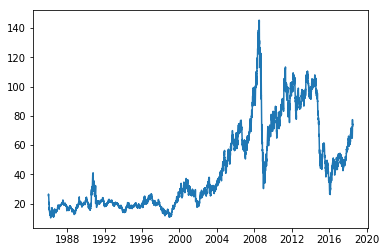

In [5]:
_ = plt.plot(ts)

Using the daily data for the time series contains too much variation, so let us resample the data by week and use this to predict the Oil prices.

In [6]:
ts_week = ts.resample('W').mean()

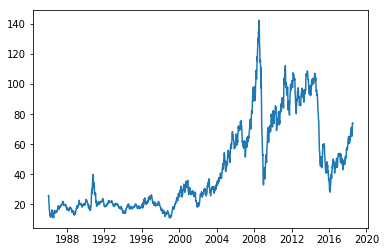

In [7]:
_ = plt.plot(ts_week)

Let's create a function to plot to moving variance and observe if it remains constant over time, however, we might not always be able to make such visual inference and hence, let us apply the Dicky Fuller Test as well to check for stationarity

In [8]:
def test_stationarity(timeseries):
    """ Fucntion to plot the moving variance and apply Dickey Fuller Test"""
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original Time Series Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value' ,'#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
        
    
    print(dfoutput)

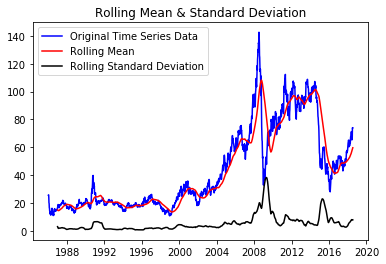

Results of Dickey-Fuller Test:

Test Statistics                  -1.914342
p-value                           0.325345
#Lags Used                       20.000000
Number of Observations Used    1677.000000
Critical Value 1%                -3.434255
Critical Value 5%                -2.863265
Critical Value 10%               -2.567688
dtype: float64


In [9]:
test_stationarity(ts_week)


Inference drawn from Dickey Fuller Test

    Because the test statictics is more than the 5% critical value and the p-value is greater than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected.
    This shows the our weekely time series is not stationary.
    #### Before we can apply ARIMA model for forecasting, we need to transform this time series into a stationary time series.



# We can apply differencing to stationarize our data. We will undergo log transformation before differencing for better results.

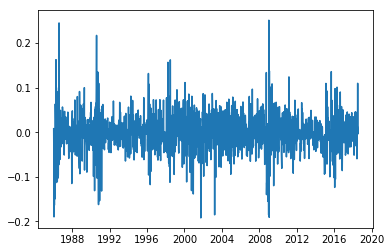

In [10]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
_ = plt.plot(ts_week_log_diff)

# Let us perform a confirmation with Dickey Fuller test again

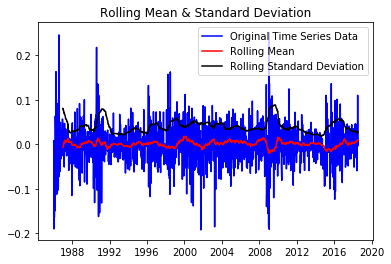

Results of Dickey-Fuller Test:

Test Statistics               -1.240939e+01
p-value                        4.378292e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.686000e+03
Critical Value 1%             -3.434235e+00
Critical Value 5%             -2.863256e+00
Critical Value 10%            -2.567683e+00
dtype: float64


In [11]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

# Inference drawn after stationarizing the time series

The test statictics is significantly less than the 1% critical value, which shows that our time series is now stationary with 99% confidence.

    #### Now we can begin to apply the ARIMA model for forecasting.



Let us define ACF & PACF

    ACF and PACF help to determine the p, d and q model parameters which we will need later as input for the ARIMA mode

In [12]:
# ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

# Plot ACF and PACF

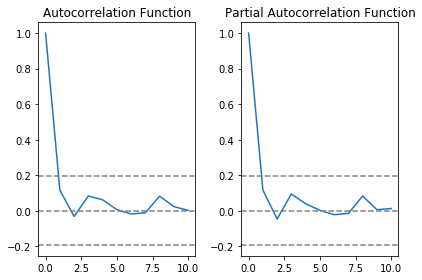

In [13]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Inferences drawn post ACF and PACF Plot

Using the plot, the value of p and q can be determined as follows

    p: The lag value where the PACF cuts off (drops to zero) for the first time. For us, this value is 2. So we have p=2

    q: The lag value where the ACF plot crosses the upper confidence interval for the first time. So, q=1.


# Now let us plot the ARIMA model

Text(0.5, 1.0, 'RSS: 3.1195')

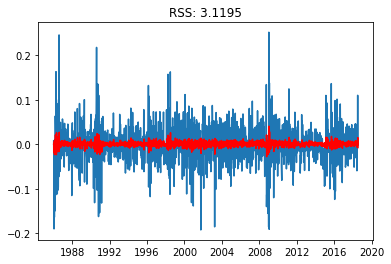

In [14]:
model = ARIMA(ts_week_log, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(f'RSS: {round(sum((results_ARIMA.fittedvalues - ts_week_log_diff)**2),4)}')

# Residual Analysis - Now let us see the results of the ARIMA model and plot the residuals

                             ARIMA Model Results                              
Dep. Variable:        D.Closing Value   No. Observations:                 1697
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2936.731
Method:                       css-mle   S.D. of innovations              0.043
Date:                Fri, 04 Oct 2019   AIC                          -5863.461
Time:                        20:50:22   BIC                          -5836.278
Sample:                    01-12-1986   HQIC                         -5853.397
                         - 07-15-2018                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0006      0.001      0.549      0.583      -0.002       0.003
ar.L1.D.Closing Value    -0.3503      0.152     -2.297      0.022      -0.649      -0.051
ar.L2.D.

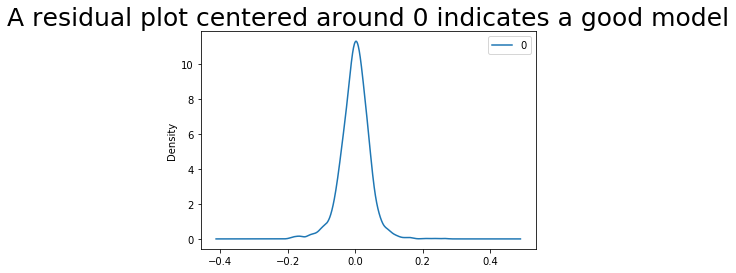

In [16]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.title('A residual plot centered around 0 indicates a good model', fontdict={'fontsize':25})
print(residuals.describe())

# Predictions

In [17]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1986-01-12    0.000622
1986-01-19    0.001482
1986-01-26   -0.006914
1986-02-02   -0.019489
1986-02-09    0.007659
Freq: W-SUN, dtype: float64


# Scaling predictions

Now that the model is returning the results, we can scale the model predictions back to the original scale.
Remove the first order differencing we did and take exponent to restore the predictions back to their original scale

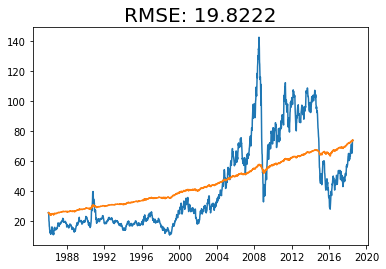

In [18]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
_ = plt.title(f'RMSE: {round(np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)),4)}', fontdict={'fontsize': 20})

Training and Testing:

    Now we need to split the data into train and test samples.
    We will use the traning data to train the ARIMA model and perform out-of-sample forecasting.
    Then we will compare the results of our out-of-sample predictions for Euro rates with the actual values from the test data

In [19]:
size = int(len(ts_week_log) -15)
train, test = ts_week_log[0: size], ts_week_log[size: len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...\n')

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print(f'Predicted= {np.exp(yhat)}, expected= {round(np.exp(obs), 4)} ')

Printing Predicted vs Expected Values...

Predicted= [64.95561351], expected= 63.098 
Predicted= [62.9286936], expected= 66.042 
Predicted= [66.57728403], expected= 67.576 
Predicted= [67.53909738], expected= 68.136 
Predicted= [68.2649765], expected= 68.38 
Predicted= [68.39834525], expected= 70.598 
Predicted= [70.93136393], expected= 71.306 
Predicted= [71.27581976], expected= 70.96 
Predicted= [70.98190462], expected= 66.852 
Predicted= [66.38991106], expected= 65.35 
Predicted= [65.45738786], expected= 66.206 
Predicted= [66.32725119], expected= 66.324 
Predicted= [66.32410746], expected= 74.026 
Predicted= [75.13306632], expected= 73.7275 
Predicted= [73.16896244], expected= 73.93 


# Validating the model

Validate the model by comparing its out-of-sample predictions for Oil prices with the actual values from the test data and calculate the Mean Squared Error (MSE)

In [20]:
error = mean_squared_error(test, predictions)
print('Mean Squared Error of Predictions...')
print('Test MSE: %.6f' %error)

predictions_series = pd.Series(predictions, index=test.index)

Mean Squared Error of Predictions...
Test MSE: 0.001402


# Forecasted values vs Observed Values plot

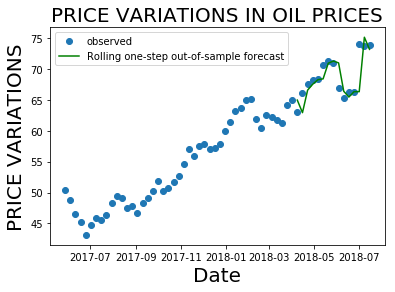

In [21]:
plt.plot(ts_week[-60:], 'o', label='observed')
plt.plot(np.exp(predictions_series), 'g', label='Rolling one-step out-of-sample forecast')
plt.title('PRICE VARIATIONS IN OIL PRICES', fontdict={'fontsize': 20})
plt.xlabel('Date', fontdict={'fontsize': 20})
plt.ylabel('PRICE VARIATIONS', fontdict={'fontsize': 20})
lenend = plt.legend(loc='upper left')